In [1]:
#importo librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs
sbs.set()
import scipy.signal
import scipy.stats as stats
import statsmodels as sm
from tqdm import tnrange, tqdm_notebook

%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
from matplotlib.colors import LogNorm

from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def index_to_ms(i):
    return (i-50)*4

In [3]:
#cargo los datos

data = loadmat('tp2_dataset/P01.mat')

In [4]:
data['data'].shape

(894, 256, 201)

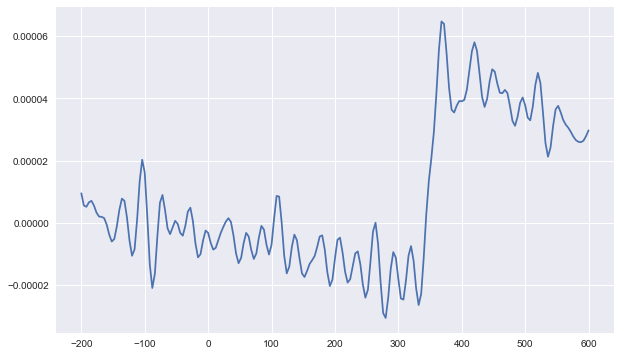

In [5]:
#Primer epoch, sensor 0

plt.plot([index_to_ms(x) for x in range(201)], data['data'][0,0,:])

## Análisis espectral

In [6]:
def mat_to_df(file):
    mat = loadmat(file)
    _df = pd.DataFrame(mat['data'].reshape(256,-1))
    return _df

In [7]:
df = mat_to_df('tp2_dataset/P01.mat')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Columns: 179694 entries, 0 to 179693
dtypes: float64(179694)
memory usage: 351.0 MB


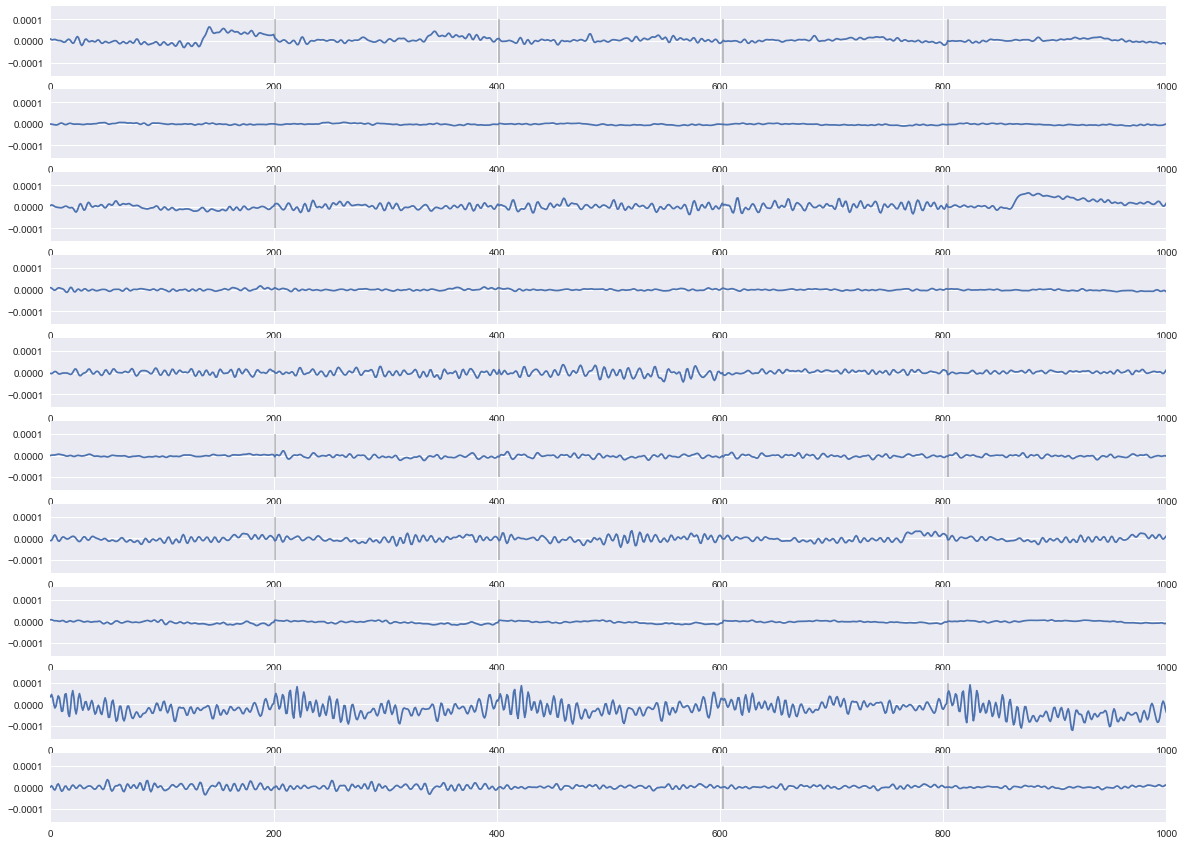

In [9]:
#Grafico algunos canales con pandas

channels = 10

fig, axes = plt.subplots(channels, 1, figsize = (20, int(channels*1.5)))

for n in range(len(axes)):
    df.loc[n,:1000].plot(ax = axes[n])
    axes[n].set_ylim(-0.00016, 0.00016)
    axes[n].vlines([201*x for x in range(1, int(df.shape[1]/201))], -0.0001, 0.0001, linewidth = 0.4)

In [10]:
def welch(sign):
    
    f, pxx = scipy.signal.welch(sign, fs = 250, nperseg = 201, noverlap = 0)

    plt.figure(figsize = (15, 6))
    plt.subplot(2,2,1)
    plt.plot(sign)
    plt.subplot(2,2,2)
    #plt.semilogy(f, pxx)
    plt.plot(f, pxx)
    print('Shape:', sign.shape)

Shape: (179694,)


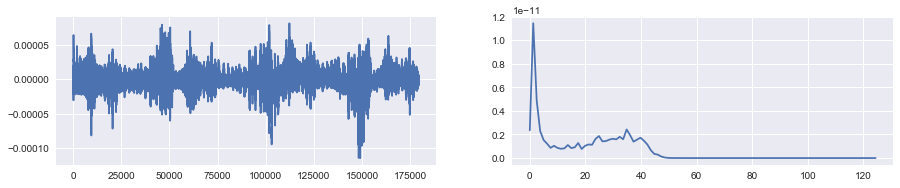

In [11]:
#Grafico el Welch (Short FFT) del electrodo 0
welch(df.loc[0])

Shape: (179694,)


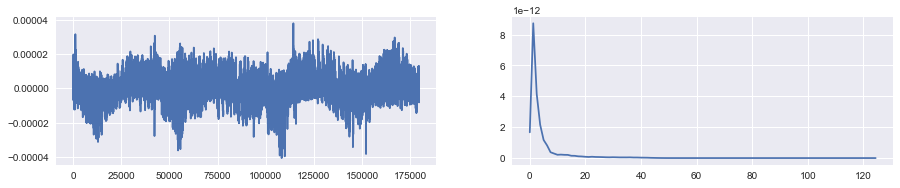

In [12]:
#Grafico el Welch (short FFT) del electrodo 250, que está bastante lejos del 0
welch(df.loc[250])

In [13]:
def alias(data):
    fig, ax = plt.subplots(1, 4, figsize = (15, 3))
    
    df.loc[9,:400].plot(ax = ax[0], title = 'Raw')
    data.rolling(window = 50).mean().plot(ax = ax[1], title = 'Moving Average')
    #win_type = 'gaussian'
    data.ewm(com = 5).mean().plot(ax = ax[2], title = 'EWM')
    data.expanding().mean().plot(ax = ax[3], title = 'Expanding')
    
    for sp in ax:
        sp.set_ylim(-0.00005, 0.00005)
        sp.set_yticklabels([])
    plt.tight_layout()

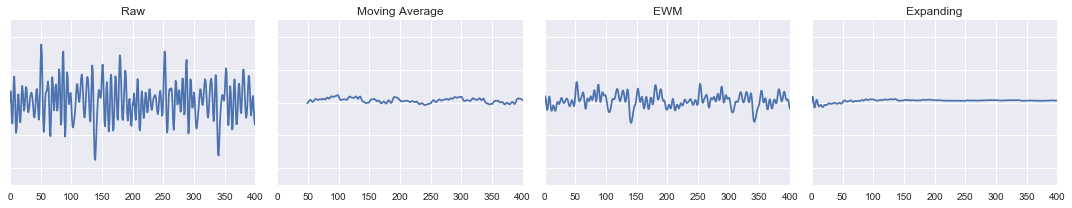

In [14]:
alias(df.loc[9,:400])

In [15]:
df.loc[:10,:].T.corr()

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.037695,0.025749,0.052365,-0.141026,0.042297,0.042728,0.020592,-0.107503,0.004001,0.090991
1,0.037695,1.000000,0.024116,0.012626,-0.018610,0.035031,0.012821,-0.031981,-0.011657,0.018482,-0.029709
2,0.025749,0.024116,1.000000,-0.015602,0.023342,-0.032597,-0.007879,-0.002936,-0.018175,-0.011649,0.023608
3,0.052365,0.012626,-0.015602,1.000000,-0.027358,-0.005667,0.027293,0.064278,-0.022017,0.030908,0.012881
4,-0.141026,-0.018610,0.023342,-0.027358,1.000000,-0.063650,-0.022841,0.025159,0.109818,-0.020229,0.003135
5,0.042297,0.035031,-0.032597,-0.005667,-0.063650,1.000000,-0.007863,-0.023641,-0.008326,0.020862,0.002824
6,0.042728,0.012821,-0.007879,0.027293,-0.022841,-0.007863,1.000000,-0.015759,0.051494,0.034829,0.024559
7,0.020592,-0.031981,-0.002936,0.064278,0.025159,-0.023641,-0.015759,1.000000,-0.008595,0.013224,0.037586
8,-0.107503,-0.011657,-0.018175,-0.022017,0.109818,-0.008326,0.051494,-0.008595,1.000000,-0.004200,-0.074672
9,0.004001,0.018482,-0.011649,0.030908,-0.020229,0.020862,0.034829,0.013224,-0.004200,1.000000,-0.015966


In [16]:
#n = 10
#df.T.corr().values[[y for x in range(n) for y in range(x,n)], [x for x in range(n) for y in range(x,n)]]

In [17]:
# Promedio los electrodos pedidos.
promedio = df.iloc[[7,43,79,130,184]].mean(axis=0)

In [18]:
f, pxx = scipy.signal.welch(promedio.loc[0:201], fs = 250, nperseg = 201, noverlap = 0)

In [19]:
print(len(pxx))

101


In [ ]:
epochs = []
frecuencias = []
potencias = []
for i in tnrange(0, len(promedio), 201):
    f, pxx = scipy.signal.welch(promedio.loc[i:i+201], fs = 250, nperseg = 201, noverlap = 0)
    frecuencias.extend(f)
    potencias.extend(pxx)
    epochs.extend([i//201 for _ in range(len(f))])

In [21]:
epochs = np.asarray(epochs)
frecuencias = np.asarray(frecuencias)
potencias = np.asarray(potencias)

#x, y, z = np.meshgrid(epochs, frecuencias, potencias, copy=False)

In [ ]:
from matplotlib.colors import LogNorm

plt.hist2d(epochs, frecuencias, weights=potencias,bins=[150,150], range=[[0,900],[0,50]], norm=LogNorm())
plt.colorbar()
plt.show()

In [23]:
def welch_canales(df):
    for i in tnrange(0, len(df)):
        f, pxx = scipy.signal.welch(df.loc[i], fs = 250, nperseg = 201, noverlap = 0)
        plt.plot(f, pxx)
    plt.xlim(0, 50)
    plt.show()

In [27]:
def welch_prom_canales(df, graficar=True):
    pxx_prom = pd.DataFrame()
    for i in range(0, len(df)):
        f, pxx = scipy.signal.welch(df.loc[i], fs = 250, nperseg = 201, noverlap = 0)
        pxx_prom = pxx_prom.append(pd.Series(pxx), ignore_index = True)
    if graficar:
        plt.plot(f, pxx_prom.mean(axis=0))
        plt.xlim(0, 50)
        plt.show()
    return f, pxx_prom.mean(axis = 0)

Widget Javascript not detected.  It may not be installed or enabled properly.


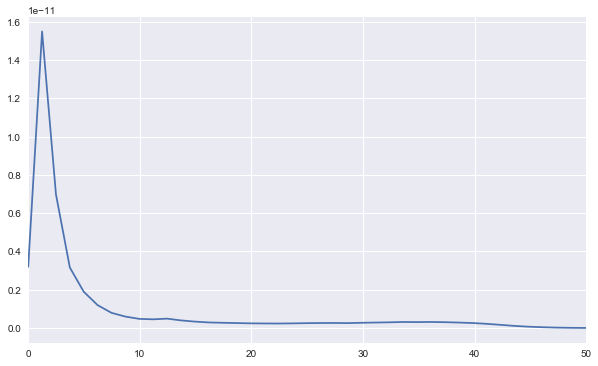

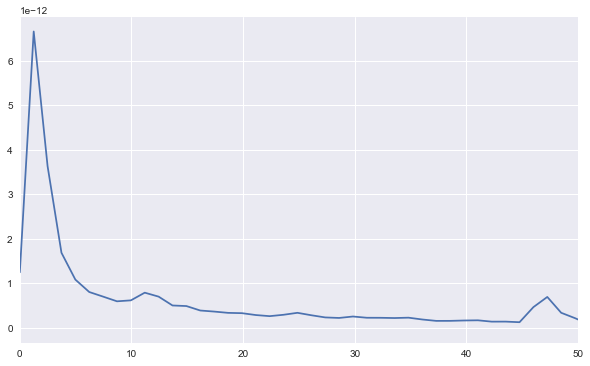

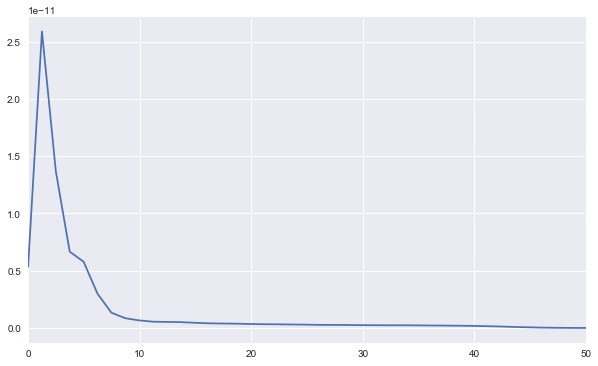

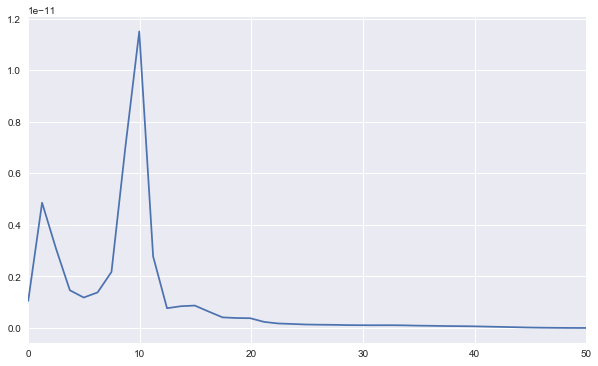

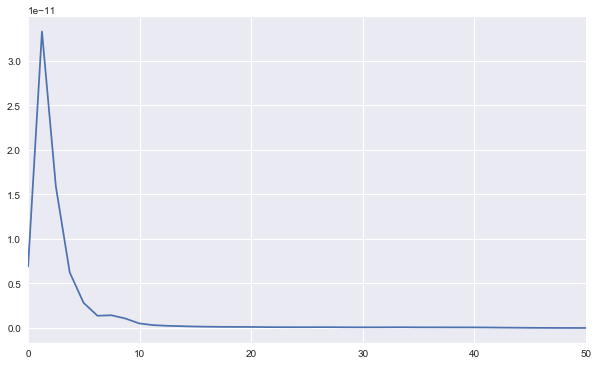

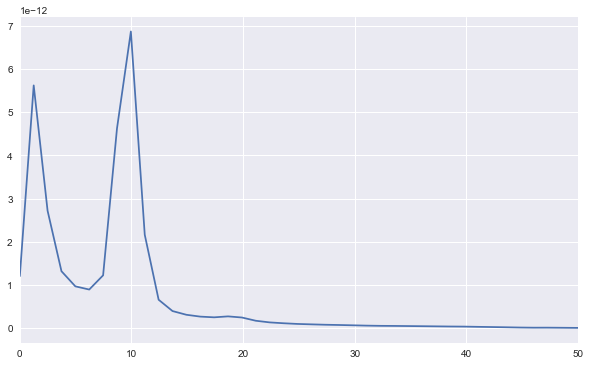

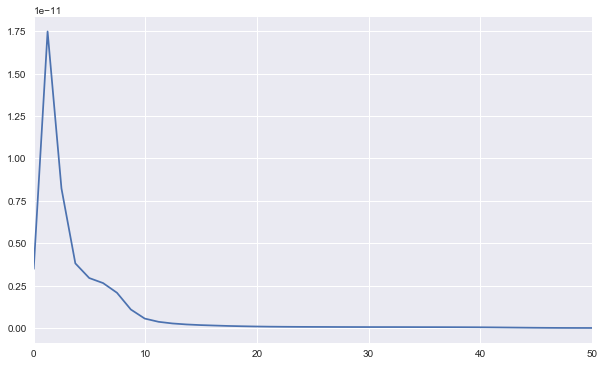

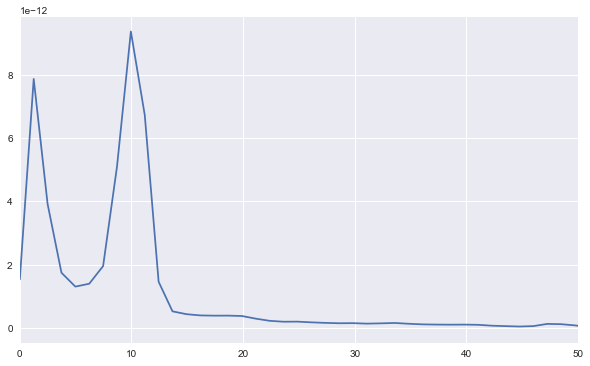

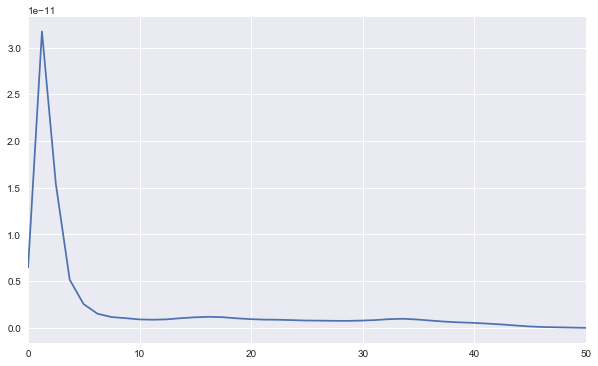

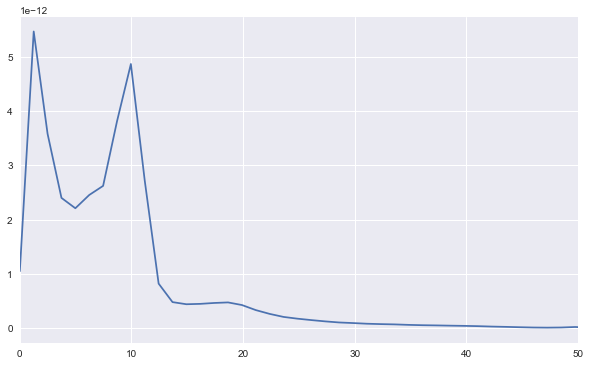

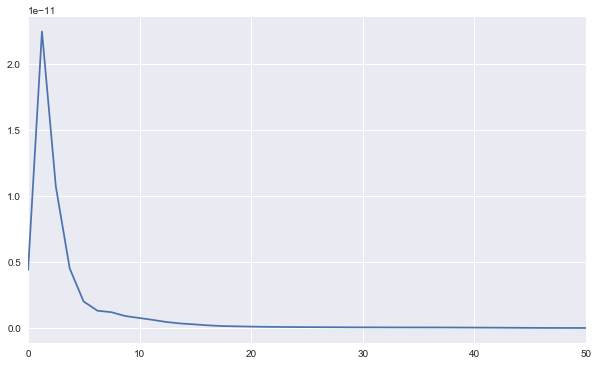

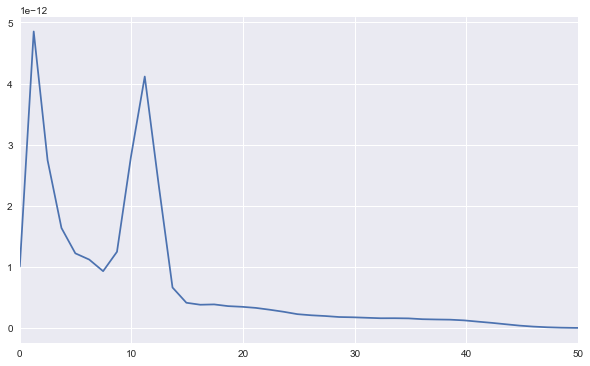

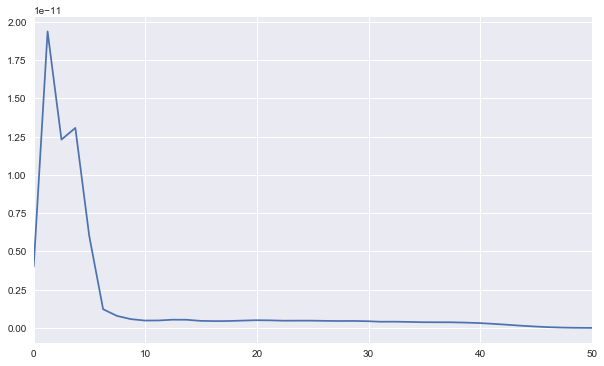

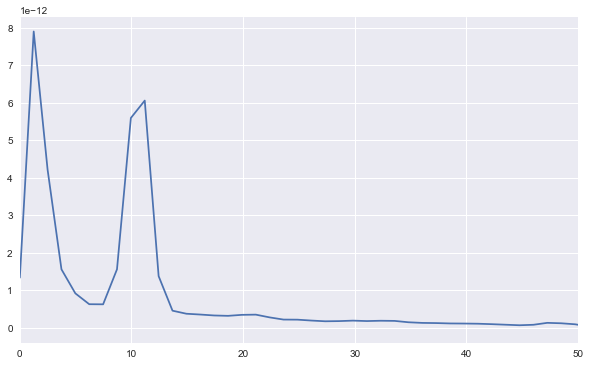

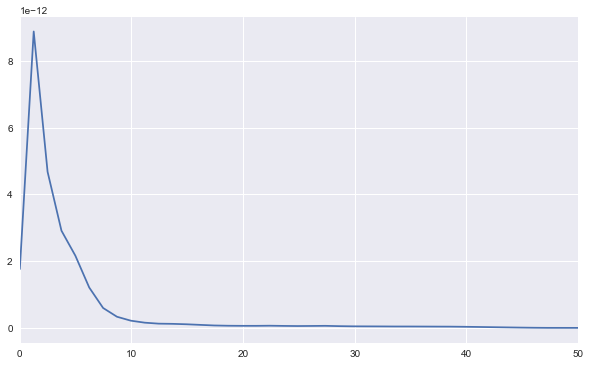

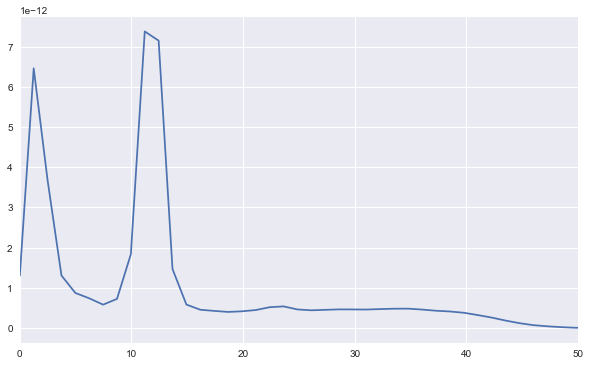

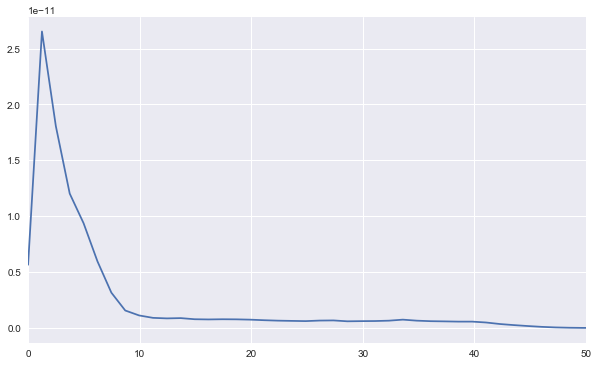

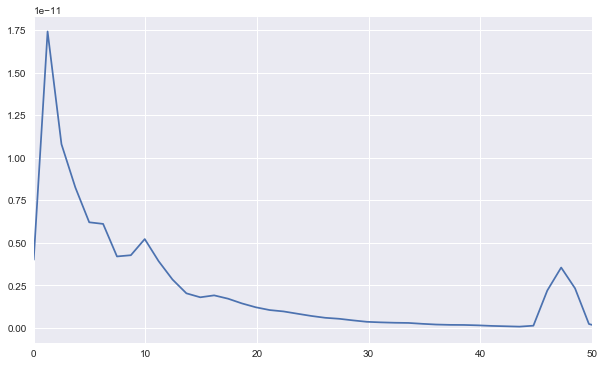

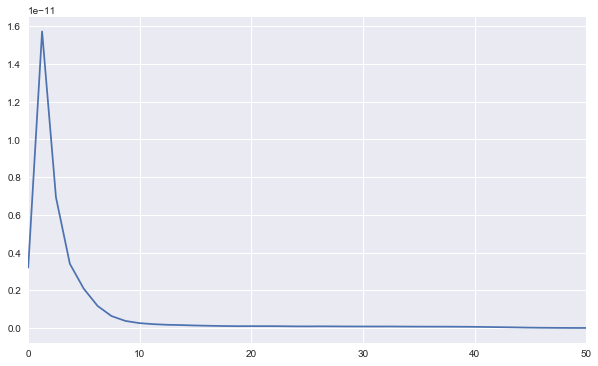

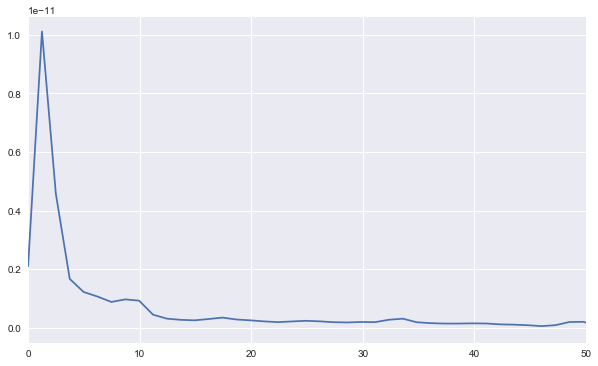

In [28]:
for i in tnrange(10):
    welch_prom_canales(sujetos_p[i])
    welch_prom_canales(sujetos_s[i])

### c) Tomar la potencia de cada sujeto en la banda Alpha y graficar cada uno de los graficos categóricos de seaborn.
¿Cuál recomendaría para graficar y comparar distribuciones?
(Si la respuesta es boxplot, pensarlo despues de leer esto)

In [29]:
def get_band(df, low, high):
    f, prom = welch_prom_canales(df, False)
    return np.sum(prom[(f >= low)&(f< high)])

def get_all_bands(sujetos):
    delta, theta, alpha, beta, gamma = [0,4], [4,8], [8, 13], [13, 30], [30, 45]
    deltas, thetas, alphas, betas, gammas = [list() for i in range(5)]
    for i in tnrange(len(sujetos)):
        deltas.append(get_band(sujetos[i], *delta))
        thetas.append(get_band(sujetos[i], *theta))
        alphas.append(get_band(sujetos[i], *alpha))
        betas.append(get_band(sujetos[i], *beta))
        gammas.append(get_band(sujetos[i], *gamma))
    return deltas, thetas, alphas, betas, gammas

In [ ]:
bandas_p = get_all_bands(sujetos_p)

In [ ]:
bandas_s = get_all_bands(sujetos_s)

In [32]:
from statsmodels.stats.diagnostic import kstest_normal

names = 'Delta, Theta, Alpha, Betas, Gammas'.split(', ')

#Pruebas de ajuste para cada banda

k = 0
dics = []
for gr_bands in [bandas_p]: #agregar bandas_s
    group = ['P', 'S'][k]
    print('Grupo: ', group)

    for i in range(len(gr_bands)):

        d = {'Grupo': group, 'Banda':names[i], 'Promedios':gr_bands[i], 'Shapiro': stats.shapiro(gr_bands[i]),
            'KS':kstest_normal(gr_bands[i])}
        for n in 'Banda, Promedios, Shapiro, KS'.split(', '):
            print(n, ':', d[n])
            print('-'*50)
        print('\n')
        dics.append(d)
        
    k+1
    
    


Grupo:  P
Banda : Delta
--------------------------------------------------
Promedios : [2.8824286459022067e-11, 5.1605161349467286e-11, 6.2372401753684759e-11, 3.2994899786160194e-11, 5.8765220966316025e-11, 4.2113873819734957e-11, 4.8758574725749444e-11, 1.8230068057347364e-11, 6.2280259802159812e-11, 2.9274732390892836e-11]
--------------------------------------------------
Shapiro : (0.9272070527076721, 0.420989066362381)
--------------------------------------------------
KS : (0.14944012478977853, 0.95420000409285144)
--------------------------------------------------


Banda : Theta
--------------------------------------------------
Promedios : [3.8795291492403752e-12, 1.0123492717942019e-11, 5.627750752119125e-12, 7.6661404581181567e-12, 5.2524794914896641e-12, 4.5175019450609999e-12, 8.0325412899575414e-12, 3.9754244177410294e-12, 1.8489712357129072e-11, 3.8875977158839123e-12]
--------------------------------------------------
Shapiro : (0.7497091293334961, 0.003539701225236058

In [33]:
#Test de hipótesis con Wilcoxon, para no asumir normalidad ni homocedasticidad

for i in range(len(bandas_p)):
    print(names[i])
    print('W: {0}\np-value: {1}\n'.format(*stats.ranksums(bandas_p[i], bandas_s[i])))
    print('M: {0}\np-value: {1}\n'.format(*stats.mannwhitneyu(bandas_p[i], bandas_s[i])))

Delta
W: 3.4016802570830453
p-value: 0.0006697294490218271

M: 5.0
p-value: 0.00038426945658138323

Theta
W: 2.0410081542498273
p-value: 0.04125001659393949

M: 23.0
p-value: 0.022577284812139504

Alpha
W: -3.3260873624811995
p-value: 0.000880743190741727

M: 6.0
p-value: 0.0005039881201883722

Betas
W: -1.0583005244258363
p-value: 0.28991845394256976

M: 36.0
p-value: 0.15374472830934066

Gammas
W: 0.15118578920369088
p-value: 0.8798291600118298

M: 48.0
p-value: 0.45486094457277765



In [ ]:
deltas_s, thetas_s, alphas_s, betas_s, gammas_s = get_all_bands(sujetos_s)

In [ ]:
deltas_p, thetas_p, alphas_p, betas_p, gammas_p = get_all_bands(sujetos_p)

#### Alpha

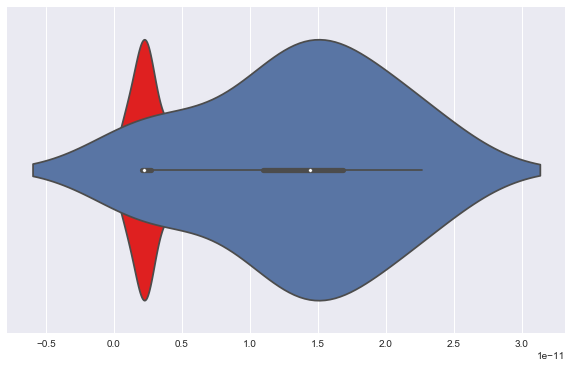

In [36]:
sbs.violinplot(alphas_p, color='red')
sbs.violinplot(alphas_s)

#### Delta

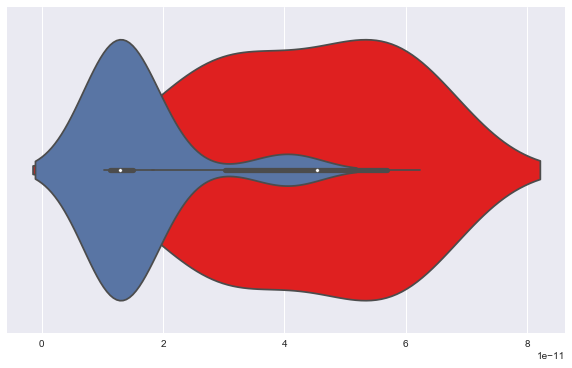

In [37]:
sbs.violinplot(deltas_p, color='red')
sbs.violinplot(deltas_s)

#### Theta

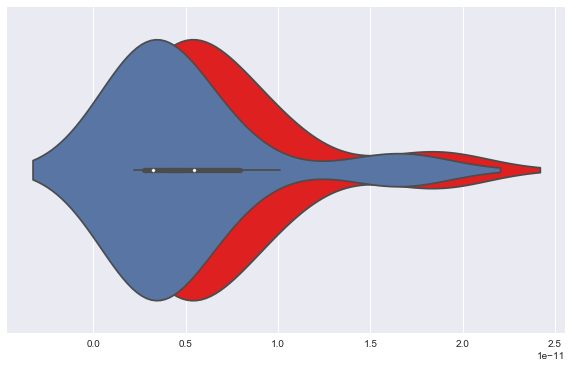

In [38]:
sbs.violinplot(thetas_p, color='red')
sbs.violinplot(thetas_s)

#### Beta

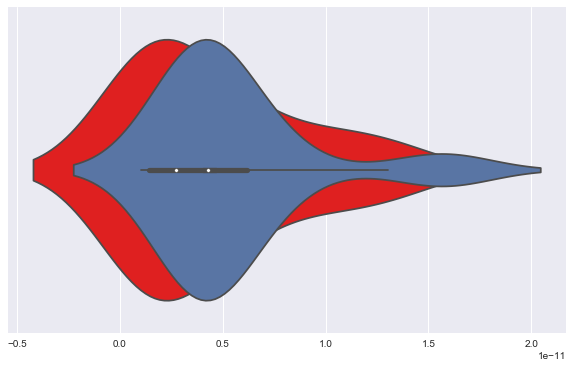

In [39]:
sbs.violinplot(betas_p, color='red')
sbs.violinplot(betas_s)

#### Gamma

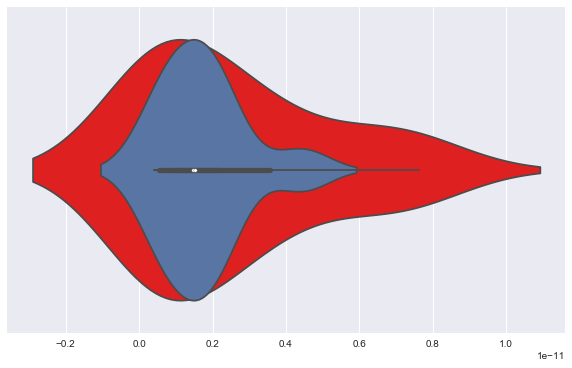

In [40]:
sbs.violinplot(gammas_p, color='red')
sbs.violinplot(gammas_s)

In [ ]:
suma_sujetos_s = [sum(x) for x in zip(*[deltas_s, thetas_s, alphas_s, betas_s, gammas_s])]
for i in tnrange(10):
    deltas_s[i] /= suma_sujetos_s[i]
    thetas_s[i] /= suma_sujetos_s[i]
    alphas_s[i] /= suma_sujetos_s[i]
    betas_s[i] /= suma_sujetos_s[i]
    gammas_s[i] /= suma_sujetos_s[i]

In [ ]:
suma_sujetos_p = [sum(x) for x in zip(*[deltas_p, thetas_p, alphas_p, betas_p, gammas_p])]
for i in tnrange(10):
    deltas_p[i] /= suma_sujetos_p[i]
    thetas_p[i] /= suma_sujetos_p[i]
    alphas_p[i] /= suma_sujetos_p[i]
    betas_p[i] /= suma_sujetos_p[i]
    gammas_p[i] /= suma_sujetos_p[i]

#### Alpha

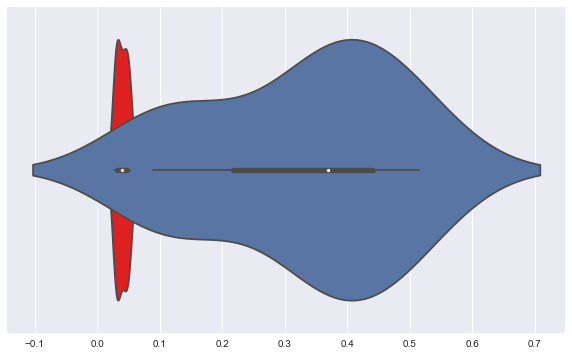

In [43]:
sbs.violinplot(alphas_p, color='red')
sbs.violinplot(alphas_s)

#### Delta

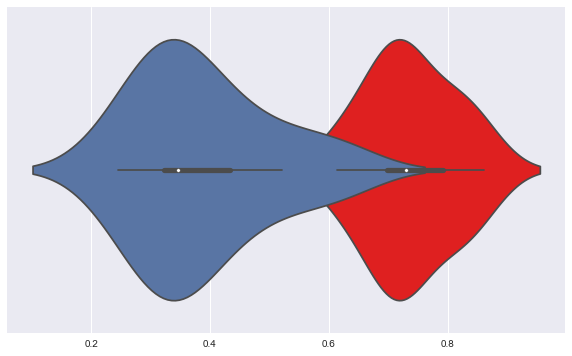

In [44]:
sbs.violinplot(deltas_p, color='red')
sbs.violinplot(deltas_s)

#### Theta

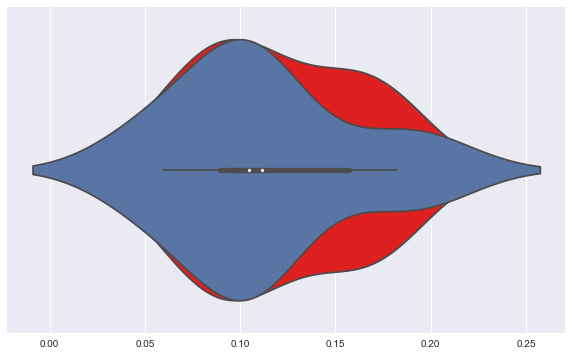

In [45]:
sbs.violinplot(thetas_p, color='red')
sbs.violinplot(thetas_s)

#### Beta

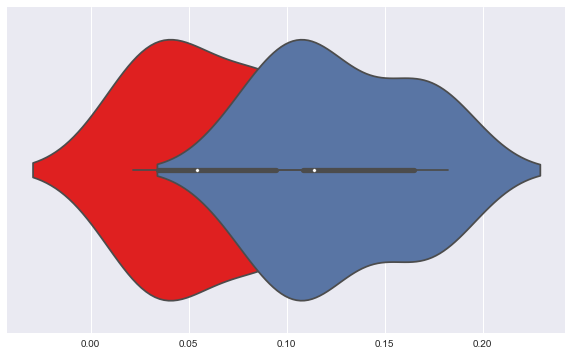

In [46]:
sbs.violinplot(betas_p, color='red')
sbs.violinplot(betas_s)

#### Gamma

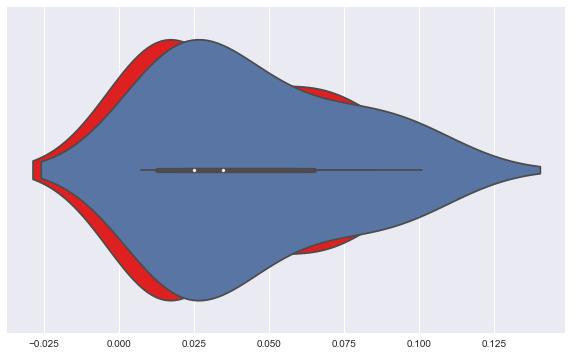

In [47]:
sbs.violinplot(gammas_p, color='red')
sbs.violinplot(gammas_s)

## 2.2 Análisis de información
### Información intra-electrodo

In [49]:
from astropy.stats import freedman_bin_width

def entropia_intra_electrodo(data_electrodo):
    ''' Recibe un array de un electrodo (todos los epochs) y devuelve su entropia.
    '''
    # para determinar la cantidad de simbolos en un sensor, usamos freedman_bin.
    width, bins = freedman_bin_width(data_electrodo, return_bins=True)
    hist, _ = np.histogram(data_electrodo, bins=bins)
    probas = [x/hist.sum() for x in hist]
    return stats.entropy(probas)

In [50]:
for electrodo in [8,101,155,232]:
    print(entropia_intra_electrodo(sujetos_s[0].loc[electrodo]))

4.64247758641
4.53285331849
4.64856610268
4.51750296565


In [ ]:
def entropia_inter_electrodo(electrodo1, electrodo2):
    # para determinar la cantidad de simbolos en un sensor, usamos freedman_bin.
    width, bins = freedman_bin_width(electrodo1 + electrodo2, return_bins=True)
    
    hist, xedges = np.histogram([(electrodo1[i],electrodo2[i]) for i in range(len(electrodo1))], bins=bins)
    probas = [x/hist.sum() for x in hist]
    return stats.entropy(probas)